In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [3]:
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN

In [4]:
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import homogeneity_score, silhouette_score

In [5]:
# bank payment transaction data. 
df = pd.read_csv('./dataset/chapter_3/banksim.csv', index_col= 0)
df.shape

(7200, 5)

In [6]:
df.head()

,age,gender,category,amount,fraud
171915,3,F,es_transportation,49.71,0
426989,4,F,es_health,39.29,0
310539,3,F,es_transportation,18.76,0
215216,4,M,es_transportation,13.95,0
569244,2,M,es_transportation,49.87,0


In [7]:
df['fraud'].value_counts()

0    7000
1     200
Name: fraud, dtype: int64

Some of the transactions are labelled as fraud; we'll treat these labels as given and will use those to validate the results.

In [8]:
df.isnull().sum()

age         0
gender      0
category    0
amount      0
fraud       0
dtype: int64

When using unsupervised learning techniques for fraud detection, you want to distinguish normal from abnormal (thus potentially fraudulent) behavior. As a fraud analyst to understand what is _normal_, you need to have a good understanding of the data and its characteristics.

## Exploring Data Analysis

In [9]:
df['category'].value_counts()

es_transportation        5975
es_food                   294
es_health                 243
es_wellnessandbeauty      198
es_fashion                 97
es_barsandrestaurants      89
es_hyper                   80
es_sportsandtoys           76
es_tech                    39
es_hotelservices           31
es_home                    24
es_travel                  18
es_leisure                 13
es_contents                13
es_otherservices           10
Name: category, dtype: int64

In [10]:
df.groupby('category').mean().round(2)

,amount,fraud
category,,
es_barsandrestaurants,43.84,0.02
es_contents,55.17,0.00
es_fashion,59.78,0.02
es_food,35.22,0.00
es_health,126.60,0.24
es_home,120.69,0.21
es_hotelservices,172.76,0.55
es_hyper,46.79,0.12
es_leisure,229.76,1.00


We can see from the table that the fraud is more prevalent in the categories such as: hotel, travel, leisure as well as sports and toys. So, watch out for those transactions.

### Customer segmentation

Let's check whether there are any obvious patterns for the clients in this data, thus whether you need to segment your data into groups, or whether the data is rather homogenous.

In [11]:
df['age'].value_counts()

2    2333
3    1718
4    1279
5     792
1     713
6     314
0      40
U      11
Name: age, dtype: int64

In [12]:
df.groupby('age').mean()

,amount,fraud
age,,
0,49.468935,0.050000
1,35.622829,0.026648
2,37.228665,0.028718
3,37.279338,0.023283
4,36.197985,0.035966
5,37.547521,0.023990
6,36.700852,0.022293
U,39.117000,0.000000


As you can see the average amount spent as well as fraud occurrence is rather similar across groups. Age group '0' stands out but since there are only 40 cases, it does not make sense to split these out in a separate group and run a separate model on them.

### Using statistics to define normal behavior

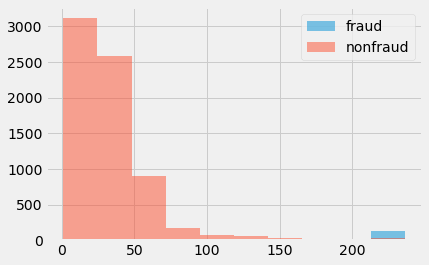

In [13]:
# Create two dataframes with fraud and non-fraud data 
df_fraud = df.loc[df.fraud == 1] 
df_non_fraud = df.loc[df.fraud == 0]

# Plot histograms of the amounts in fraud and non-fraud data 
plt.hist(df_fraud.amount, alpha=0.5, label='fraud')
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud')
plt.legend()
plt.show()

As the number fraud observations is much smaller, it is difficult to see the full distribution. Nonetheless, you can see that the fraudulent transactions tend to be on the larger side relative to normal obervations. This is good news, as it helps us later in detecting fraud from non-fraud.

In [14]:
df.shape

(7200, 5)

## Clustering

In [15]:
df['gender'].value_counts()

F    3972
M    3212
E      11
U       5
Name: gender, dtype: int64

In [16]:
df['M'] = df['gender'] == 'M'
df = df.drop(['gender'], axis= 1)

In [17]:
# Drop the category 'U' from `age`.
df = df.loc[df['age'] != 'U']

In [18]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df[['category']])

OneHotEncoder(handle_unknown='ignore')

In [19]:
cats = enc.categories_[0]
cats

array(['es_barsandrestaurants', 'es_contents', 'es_fashion', 'es_food',
       'es_health', 'es_home', 'es_hotelservices', 'es_hyper',
       'es_leisure', 'es_otherservices', 'es_sportsandtoys', 'es_tech',
       'es_transportation', 'es_travel', 'es_wellnessandbeauty'],
      dtype=object)

In [20]:
len(cats)

15

In [21]:
df_cat = enc.transform(df[['category']]).toarray()

In [22]:
df_cat.shape

(7189, 15)

In [23]:
df_cat = pd.DataFrame(df_cat, columns= cats)
df_cat.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
es_barsandrestaurants,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
es_contents,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
es_fashion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
es_food,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
es_health,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
es_home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
es_hotelservices,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
es_hyper,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
es_leisure,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
es_otherservices,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
labels = df['fraud']
df = df.drop(['category', 'fraud'], axis= 1)

df.shape

(7189, 3)

In [25]:
df.head(3)

,age,amount,M
171915,3,49.71,False
426989,4,39.29,False
310539,3,18.76,False


In [26]:
df = pd.concat([df.reset_index(), df_cat], axis= 1)
df.shape

(7189, 19)

In [27]:
# Take the float values of df for X
X = df.values.astype(np.float)

# Define the scaler and apply to the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

A very commonly used clustering algorithm is K-means clustering. For fraud detection, K-means clustering is straightforward to implement and relatively powerful in predicting suspicious cases. It is a good algorithm to start with when working on fraud detection problems. However, fraud data is oftentimes very large, especially when you are working with transaction data. __MiniBatch K-means__ is an efficient way to implement K-means on a large dataset.

In [28]:
# Define the model 
kmeans = MiniBatchKMeans(n_clusters=8, random_state=0)

# Fit the model to the scaled data
kmeans.fit(X_scaled)

C:\Users\Heschmat\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1024 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


MiniBatchKMeans(random_state=0)

Now, before exploring whether this model is any good at flagging fraud, we need to figure our what the right number of clusters to use is. It is important to get the number of clusters right, especially when you want to use the outliers of those clusters as fraud predictions.

''

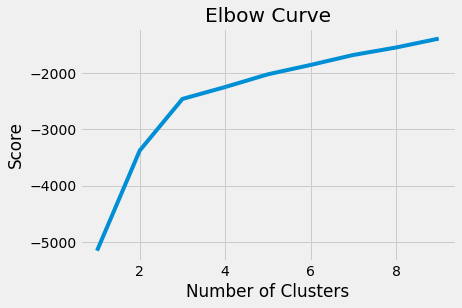

In [29]:
# Define the range of clusters to try
clust = range(1, 10)

# Run MiniBatch Kmeans over the number of clusters
params = {'random_state': 0, 'batch_size': 1024}
kmeans = [MiniBatchKMeans(n_clusters= i, **params) for i in clust]

# Obtain the score for each model
scores = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]

# Plot the models and their respective score 
plt.plot(clust, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
;

Now you can see that the optimal number of clusters should probably be at around 3 clusters, as that is where the elbow is in the curve. We'll use this in the next exercise as our baseline model, and see how well this does in detecting fraud

## Detecting outliers

Let's use the K-means algorithm to predict fraud, and compare those predictions to the actual labels that we have, to sense check our results. The __fraudulent transactions__ are typically flagged as the observations that are furthest aways from the __cluster centroid__. For that, we need to know how to determine the __cut-off__.

In [30]:
# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.3, random_state=0)

# Define K-means model 
kmeans = MiniBatchKMeans(n_clusters=3, random_state=42, batch_size= 1024).fit(X_train)

# Obtain predictions and calculate distance from cluster centroid
X_test_clusters = kmeans.predict(X_test)
X_test_clusters_centers = kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x, y in zip(X_test, X_test_clusters_centers[X_test_clusters])]

# Create fraud predictions based on outliers on clusters 
# Flag all observations to be fraud/outlier in each cluster,
# if they are in the top 5th percentile in distance from their cluster centroid.
km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, 95)] = 1
km_y_pred[dist < np.percentile(dist, 95)] = 0

In [31]:
roc_auc_score(y_test, km_y_pred).round(3)

0.82

In [32]:
def plot_confusion_matrix(km_cm):
    df_cm = pd.DataFrame(km_cm, ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
    plt.figure(figsize = (8,4))
    sns.set(font_scale=1.4) 
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')
    plt.show()

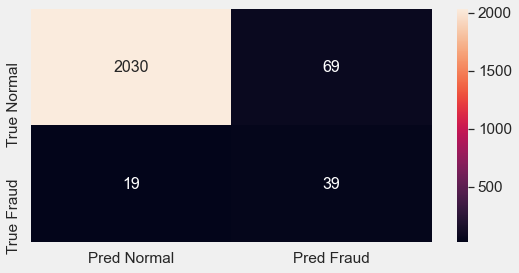

In [33]:
# Create a confusion matrix
km_cm = confusion_matrix(y_test, km_y_pred)

# Plot the confusion matrix in a figure to visualize results 
plot_confusion_matrix(km_cm)

Q: If you were to decrease the percentile used as a cutoff point in the previous exercise to 93% instead of 95%, what would that do to your prediction results?


A: By lowering the threshold for cases flagged as fraud, you flag more cases overall and thus have a higher chance of catching more fraud, but this does come at a cost of more false positives amongst those that are flagged.

## DBSCAN

The advantage of DBSCAN - a density-based clustering method- is that you do not need to define the number of clusters beforehand. Moreover, DBSCAN can handle weirdly shaped data (i.e. non-convex) much better than K-means can.

This time, we won't be taking the outliers of the clusters and use that for fraud, rather we label the smallest clusters in the data as fraud.

In [34]:
# Initialize and fit the DBSCAN model
dbs = DBSCAN(eps=.9, min_samples=10, n_jobs=-1).fit(X_scaled)

# Obtain the predicted labels and calculate number of clusters
pred_labels = dbs.labels_
n_clusters = len(set(pred_labels)) - (1 if -1 in labels else 0)

# Print performance metrics for DBSCAN
print('Estimated number of clusters: %d' % n_clusters)
print("Homogeneity: %0.3f" % homogeneity_score(labels, pred_labels))
print("Silhouette Coefficient: %0.3f" % silhouette_score(X_scaled, pred_labels))

Estimated number of clusters: 23
Homogeneity: 0.612
Silhouette Coefficient: 0.565


The number of clusters is much higher than with K-means. For fraud detection this is for now OK, as we are only interested in the smallest clusters, since those are considered as abnormal. Now let's have a look at those clusters and decide which one to flag as fraud.

### Assessing smallest clusters

In [35]:
# Count observations in each cluster number
counts = np.bincount(pred_labels[pred_labels >= 0])

# Print the result
print(counts)

# Sort the sample counts of the clusters and take the top 3 smallest clusters
smallest_clusters = np.argsort(counts)[:3]
print('\n\nSmallest clusters are: ', smallest_clusters)

# Print the counts of the smallest clusters only
print('Their counts are: ', counts[smallest_clusters])

[3252  145 2714   55  174  119  122   98   54   15   76   43   25   51
   47   42   15   25   20   15   19   10]


Smallest clusters are:  [21 19 16]
Their counts are:  [10 15 15]


In [36]:
# Or, using series
counts = pd.Series(pred_labels).value_counts().sort_index()
counts

-1       53
 0     3252
 1      145
 2     2714
 3       55
 4      174
 5      119
 6      122
 7       98
 8       54
 9       15
 10      76
 11      43
 12      25
 13      51
 14      47
 15      42
 16      15
 17      25
 18      20
 19      15
 20      19
 21      10
dtype: int64

In [37]:
counts.sort_values(ascending= True).head()

21    10
19    15
16    15
9     15
20    19
dtype: int64

So now we know which smallest clusters we could flag as fraud. If we were to take more of the smallest clusters, we'd cast out net wider and catch more fraud, however, most likely also more false positives. It is up to the fraud analyst to find the right amount of cases to flag and to investigate.


In reality, you often don't have reliable labels and this where a fraud analyst can help you validate the results. He/She can check your results and see whether the cases you flagged are indeed suspicious. You can also check historically known cases of fraud and see whether your model flags them.

In [38]:
# Create a dataframe of the predicted cluster numbers and fraud labels 
res = pd.DataFrame({'clusternr':pred_labels,'fraud':labels})

# Create a condition flagging fraud for the smallest clusters 
res['predicted_fraud'] = np.where(res['clusternr'].isin([21, 19, 16, 9]), 1 , 0)

# Run a crosstab on the results 
pd.crosstab(res['fraud'], res['predicted_fraud'],
            rownames=['Actual Fraud'],
            colnames=['Flagged Fraud'])

Flagged Fraud,0,1
Actual Fraud,,
0,6964,25
1,170,30


How does this compare to the K-means model?

The good thing is: more than half of all the flagged cases are actually fraud! Since we only took the 4 smallest clusters, by definition we flag less cases of fraud, so we catch less; but we also have less false positives.


However, we are missing quite a lot of fraud cases. We could improve that by increasing the amount of smallest clusters we flag, at the cost of more false positives of course.

Next, we'll learn how to further improve fraud detection models by including text analysis.